# Assessing The Fairness of SAT Tests

## 1. Introduction

The SAT is a test that high school seniors in the United States take every year. The SAT has three sections, each of which is worth 800 points. Combining the scores of these three sections, universities in the US use the SAT to determine which students to admit. The presumption here is that better students achieve higher SAT scores, making it a fair test to assess and select future university students. But is the SAT actually a fair test? This project will examine the fairness of the SAT by comparing demographic factors such as income, race and gender. The data that will be used is a combination of multiple datasets. On the one hand, a combination of six datasets provides us with various metrics about individual schools in New York City. On the other hand, a survey of parents, teachers and students, held in New York City in 2011, adds individual student metrics. New York is a city with a very diverse population, giving its data high potential to answer our research question.

## 2. Data cleaning and preparation

#### Reading the school-level datasets and merging them into one dataframe

In [8]:
import pandas as pd
import numpy
import re

data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]

data = {}

for f in data_files:
    d = pd.read_csv("schools/{0}".format(f))
    data[f.replace(".csv", "")] = d

#### Reading in the surveys

In [9]:
all_survey = pd.read_csv("schools/survey_all.txt", delimiter="\t", encoding='windows-1252')
d75_survey = pd.read_csv("schools/survey_d75.txt", delimiter="\t", encoding='windows-1252')
survey = pd.concat([all_survey, d75_survey], axis=0)

survey["DBN"] = survey["dbn"]

#selecting relevant columns
survey_fields = [
    "DBN", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_11", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]
survey = survey.loc[:,survey_fields]
data["survey"] = survey

#### Adding DBN columns

In [10]:
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

def pad_csd(num):
    string_representation = str(num)
    if len(string_representation) > 1:
        return string_representation
    else:
        return "0" + string_representation
    
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(pad_csd)
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]

#### Converting column data types to numeric

In [11]:
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in cols:
    data["sat_results"][c] = pd.to_numeric(data["sat_results"][c], errors="coerce")

data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]

def find_lat(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lat = coords[0].split(",")[0].replace("(", "")
    return lat

def find_lon(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lon = coords[0].split(",")[1].replace(")", "").strip()
    return lon

data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(find_lat)
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(find_lon)

data["hs_directory"]["lat"] = pd.to_numeric(data["hs_directory"]["lat"], errors="coerce")
data["hs_directory"]["lon"] = pd.to_numeric(data["hs_directory"]["lon"], errors="coerce")

#### Condensing the datasets

In [12]:
class_size = data["class_size"]
class_size = class_size[class_size["GRADE "] == "09-12"]
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]

class_size = class_size.groupby("DBN").agg(numpy.mean)
class_size.reset_index(inplace=True)
data["class_size"] = class_size

data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]

data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]

#### Converting AP scores to numeric data type

In [13]:
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols:
    data["ap_2010"][col] = pd.to_numeric(data["ap_2010"][col], errors="coerce")

#### Combining the datasets

In [14]:
combined = data["sat_results"]

combined = combined.merge(data["ap_2010"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on="DBN", how="left")

to_merge = ["class_size", "demographics", "survey", "hs_directory"]

for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")

combined = combined.fillna(combined.mean())
combined = combined.fillna(0)

#### Adding a school district column for mapping

In [15]:
def get_first_two_chars(dbn):
    return dbn[0:2]

combined["school_dist"] = combined["DBN"].apply(get_first_two_chars)

## 3. Analysis

#### Examining correlations

In [16]:
correlations = combined.corr()
correlations = correlations["sat_score"]
# print(correlations)

### 3.1 Plotting survey correlations

In [17]:
# Remove DBN since it's a unique identifier, not a useful numerical value for correlation.
survey_fields.remove("DBN")

import matplotlib.pyplot as plt
%matplotlib inline

print(survey_fields)

['rr_s', 'rr_t', 'rr_p', 'N_s', 'N_t', 'N_p', 'saf_p_11', 'com_p_11', 'eng_p_11', 'aca_p_11', 'saf_t_11', 'com_t_11', 'eng_t_11', 'aca_t_11', 'saf_s_11', 'com_s_11', 'eng_s_11', 'aca_s_11', 'saf_tot_11', 'com_tot_11', 'eng_tot_11', 'aca_tot_11']


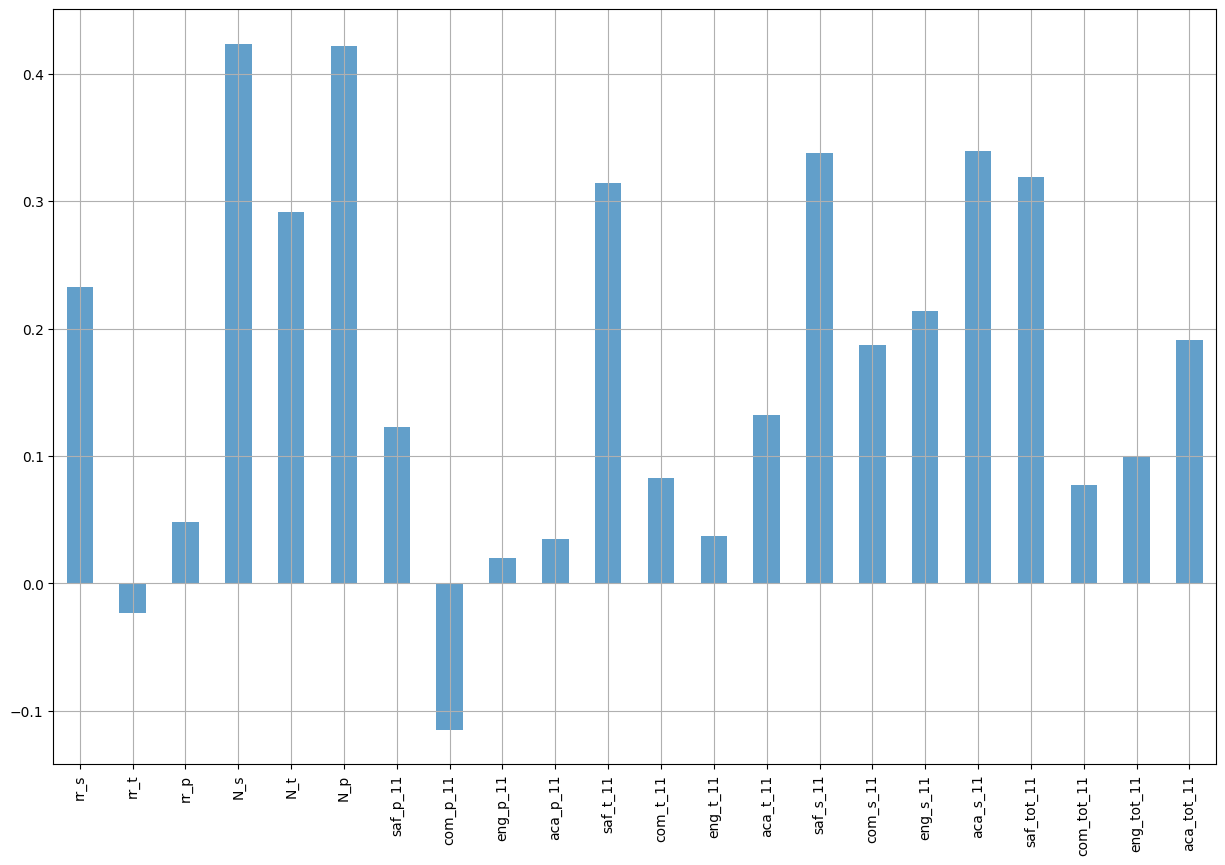

In [18]:
#tips_filtered = tips_df.reindex(columns = filtered_columns)

combined.corr()["sat_score"][survey_fields].plot.bar(grid='on', 
                                                     figsize=(15,10),
                                                     alpha=0.7)
                                                    

The above plot shows the correlation between SAT scores and a number of variables from the New York City School Survey. The plot confirms a number of things:
- SAT scores correlate quite significantly with the numbers of student, parent and teacher respondents to the NYC School Survey
- SAT scores correlate significantly as well with the reported Safety and Respect scores from both students and teachers
- SAT scores also correlate with academic expectations scores based on student responses
- Other variables from the survey seem to correlate weaker with SAT scores

These numbers could suggest that schools with a more engaging and participating community of students, parents and teachers achieve higher SAT scores on average. More strikingly, the figure suggests that perceptions of safety and respect have positive effects on SAT scores. Combined, these two factors might also boost confidence among students and result in higher academic expectations among students that feel safe and respected at school.

### 3.2 Exploring Safety and SAT Scores

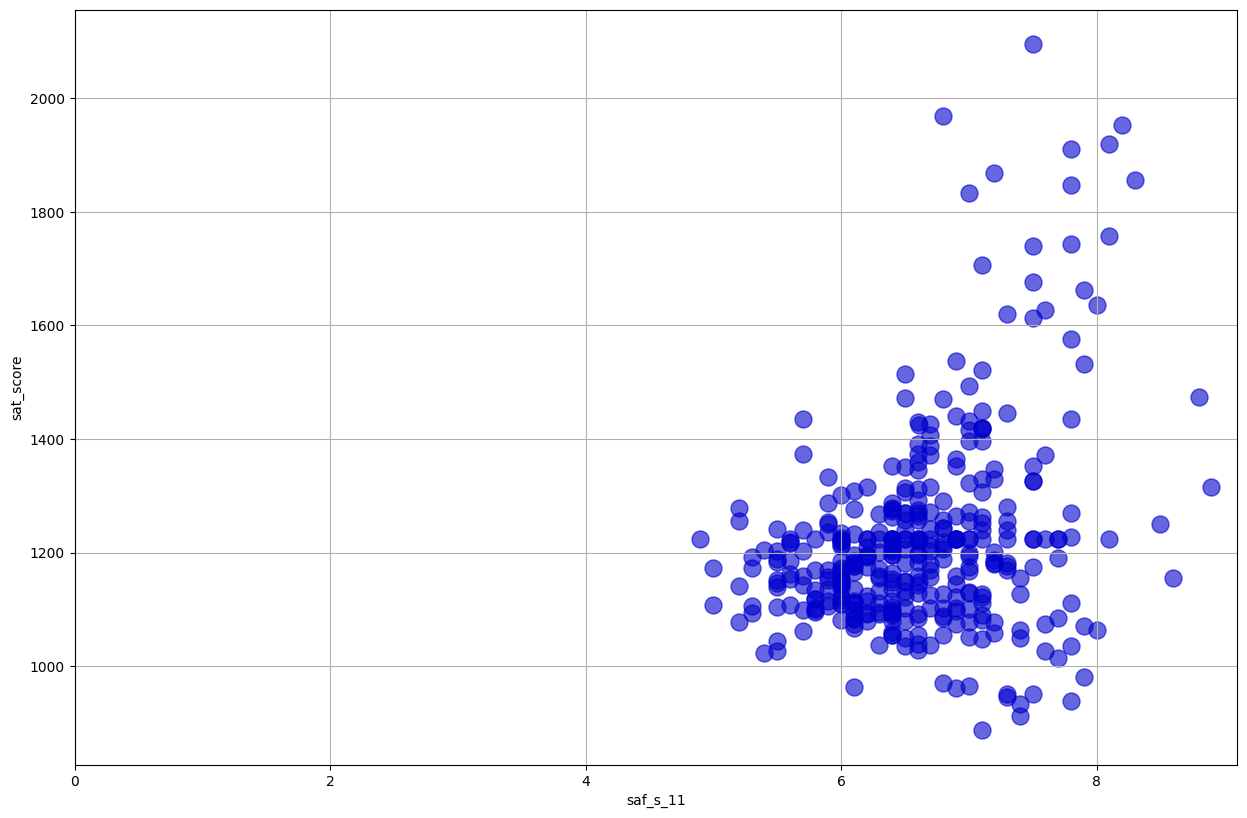

In [19]:
combined.plot.scatter('saf_s_11',
                     'sat_score',
                      s=150,
                      figsize=(15,10),
                      grid='on',
                      color='mediumblue',
                      alpha=0.6,
                      xlim=0)

The scatterplot above shows the correlation between students' perceived safety and respect at school and their SAT scores. It shows a large cluster in the left bottom. This indicates that there is a substantial group of schools where students do not feel safe and respected, and this is reflected in relatively low average SAT scores. This correlation is not significantly strong however; higher levels of perceived safety and respect do not necessarily predict higher SAT scores. That being said, the top ranking schools in terms of SAT scores all appear to fall within the Safety and Respect Score range of roughly 6.7 to 8.5. At the same time, the majority of the lower ranking schools fall within the range of 5 to 7.

In [20]:
boro = combined.groupby('boro')
boro_means = boro['sat_score'].mean()
print(boro_means.sort_values(ascending=False))

boro
Staten Island    1382.500000
Queens           1286.753032
Manhattan        1278.331410
Brooklyn         1181.364461
Bronx            1157.598203
Name: sat_score, dtype: float64


The table above shows the mean SAT scores for each of New York City's boroughs. It shows a striking difference between the top borough, Staten Island, the next two boroughs, and the bottom two boroughs, each step compromising about one hundred points. Looking at the demographic and socio-economic differences between these boroughs, a few things stand out:

- The top ranked borough, Staten Island, is the least populated of the five boroughs. It subsequently has, by a large distance, the lowest population density. Additionally, Staten Island has by far the lowest poverty ratings, is one of the most affluent boroughs and has the smallest percentage of minorities.
- Brooklyn and The Bronx seem to be the exact opposite of Staten Island, in various aspects. These two boroughs are much more densely populated, have the highest rates of poverty and the lowest mean househould incomes, as well as the largest minority communities. 

These findings suggest that demographics and socio-economic circumstances could have a considerable impact on learning outcomes.

### 3.3 Exploring Race and SAT Scores

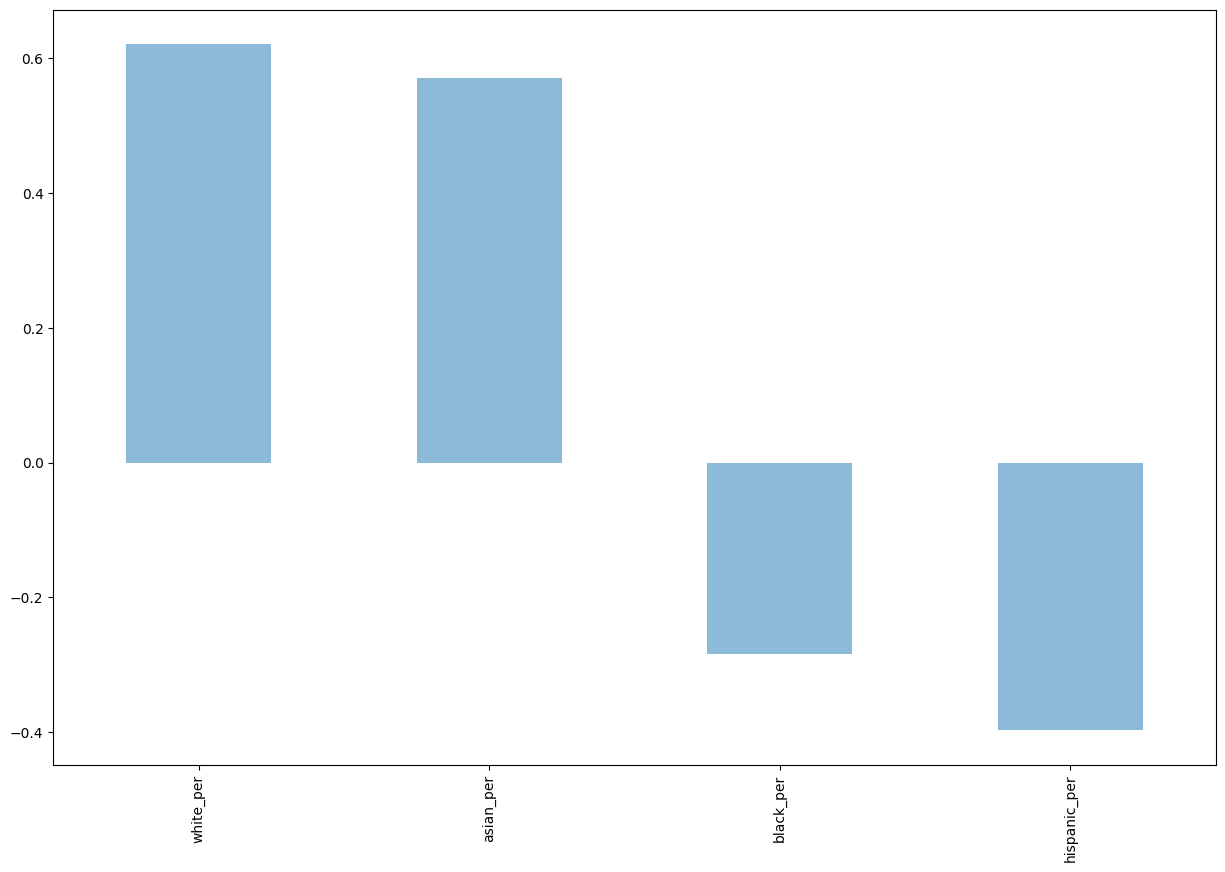

In [21]:
dem = ['white_per', 'asian_per', 'black_per', 'hispanic_per']
combined.corr()["sat_score"][dem].sort_values(ascending=False).plot(kind='bar',
                                                                    figsize=(15,10),
                                                                    alpha=0.5)
                                                                    


In this bar plot we have displayed the correlation between SAT scores and different population groups. It shows a strong positive correlation with SAT scores for white and Asian students, as well as a fairly strong negative correlation for black and hispanic students. In concrete terms this means that white and Asian students are much more likely to achieve high SAT scores than black and hispanic students. This corresponds with our findings about the correlation between SAT scores and boroughs, as the boroughs with larger black and hispanic communities showed lower average SAT scores.

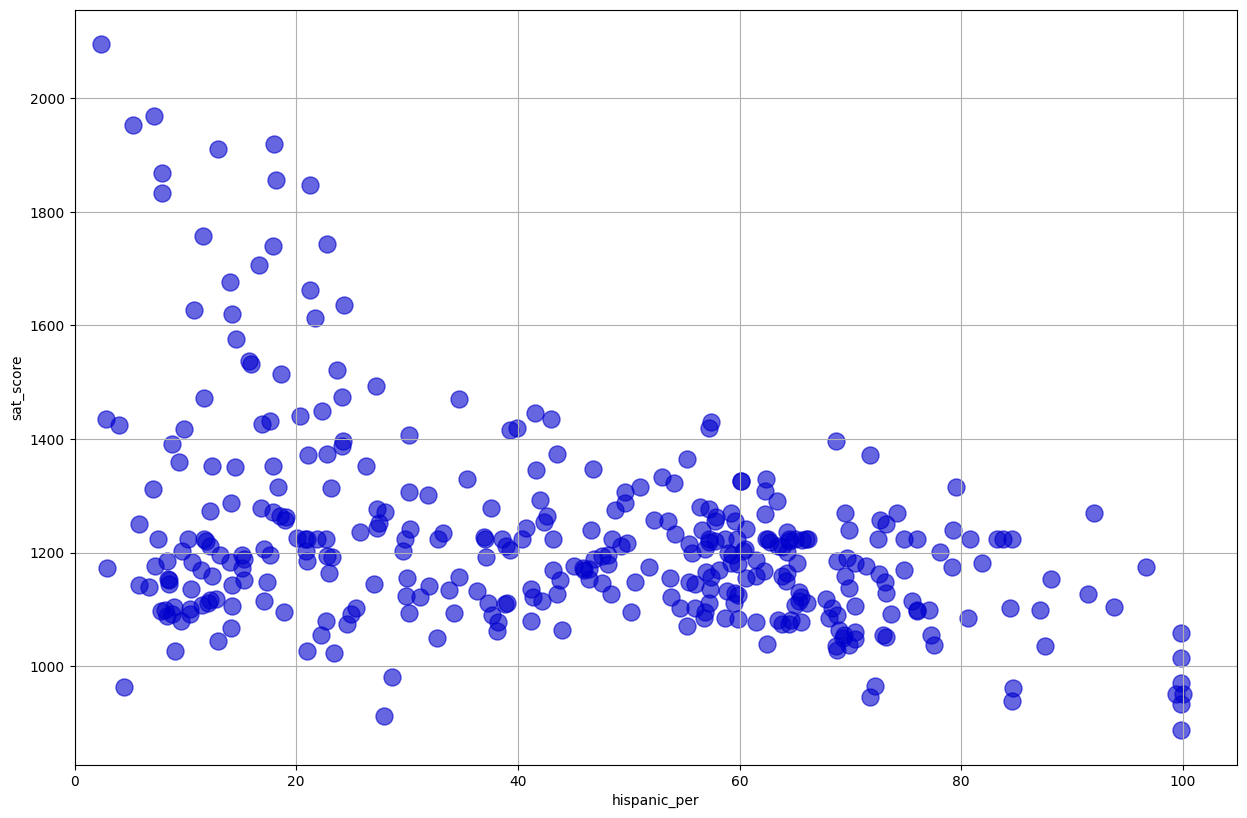

In [22]:
combined.plot.scatter('hispanic_per',
                     'sat_score',
                      s=150,
                      figsize=(15,10),
                      grid='on',
                      alpha=0.6,
                      color='mediumblue',
                      xlim=0)


Looking at the percentage of hispanic students per school and their average SAT school, we observe a somewhat negative trend. The highest scoring schools generally have the lowest percentages of hispanic students, and a big cluster in the bottom right shows that many majority hispanic schools produce relatively low SAT outcomes. There is also a big cluster to be found in the bottom left corner, indicating that there are also many low scoring schools with few hispanic students. Based on our previous findings, it has to be assumed that majority black schools make up a considerable proportion of these schools. An interesting observation is the small group of schools that are one hundred percent hispanic. These schools will be investigated next.

In [23]:
hisp = combined[combined['hispanic_per'] > 95]
print(hisp['SCHOOL NAME'])

44                         MANHATTAN BRIDGES HIGH SCHOOL
82      WASHINGTON HEIGHTS EXPEDITIONARY LEARNING SCHOOL
89     GREGORIO LUPERON HIGH SCHOOL FOR SCIENCE AND M...
125                  ACADEMY FOR LANGUAGE AND TECHNOLOGY
141                INTERNATIONAL SCHOOL FOR LIBERAL ARTS
176     PAN AMERICAN INTERNATIONAL HIGH SCHOOL AT MONROE
253                            MULTICULTURAL HIGH SCHOOL
286               PAN AMERICAN INTERNATIONAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object


Having filtered out the schools with more than 95 percent hispanic students, and having researched the remaining schools, we observe that most of these schools are multicultural schools by purpose. These schools are often relatively novel, and established purposefully to integrate hispanic migrants.

In [24]:
low_hisp = combined[(combined['hispanic_per'] < 10) & (combined['sat_score'] > 1800)]
print(low_hisp['SCHOOL NAME'])

37                                STUYVESANT HIGH SCHOOL
151                         BRONX HIGH SCHOOL OF SCIENCE
187                       BROOKLYN TECHNICAL HIGH SCHOOL
327    QUEENS HIGH SCHOOL FOR THE SCIENCES AT YORK CO...
356                  STATEN ISLAND TECHNICAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object


Researching the above five schools, the following things stand out:
- Each borough is represented by one school
- All five schools are so-called magnets, which are prestigious, specialized schools with competitive entrance processes
- Schools of this type of education have been subject to criticism for lacking racial diversity

Summed up, the top ranking schools are highly competitive and specialized schools that seemingly attract top talents within their respective borough. Entry opportunties for the hispanic and other disadvantaged communities appear to be minimal.

### 3.4 Exploring Gender and SAT Scores

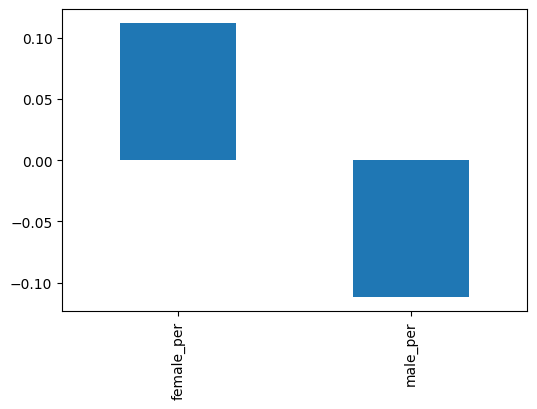

In [25]:
combined.corr()['sat_score'][['male_per', 'female_per']].sort_values(ascending=False).plot(kind='bar')

The plot above shows the correlation between SAT scores and gender. It shows a slightly positive correlation for female students and a slightly negative correlation for males. While this is not a very significant statistic, it would be interesting to explore this difference.

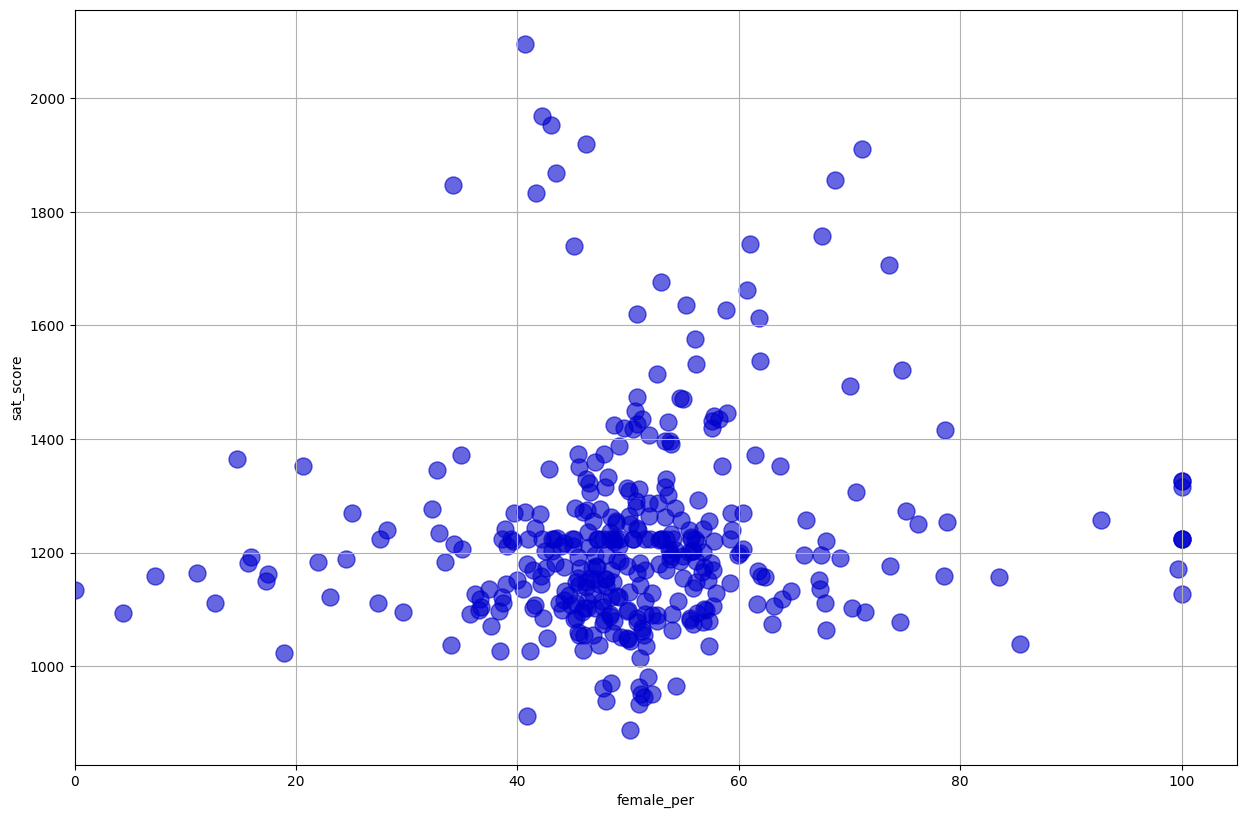

In [26]:
combined.plot.scatter('female_per',
                      'sat_score',
                      s=150,
                      figsize=(15,10),
                      grid='on',
                      alpha=0.6,
                      color='mediumblue',
                      xlim=0)

This scatter plot shows the correlation between schools' percentage of female students and their average SAT scores. It doesn't seem to show any particular correlation, with a big cluster in the center and a few groups in different directions. The plot shows that there are a few all-female schools, but they appear to perform slightly above average at best. Some of the best performing schools have a nearly even gender distribution. Interestingly, there's also a small group of schools with over sixty percent of female students that achieve remarkably high SAT scores. These scores will be researched further next.

In [27]:
fem = combined[(combined['female_per'] > 60) & (combined['sat_score'] > 1700)]
print(fem['SCHOOL NAME'])

5                         BARD HIGH SCHOOL EARLY COLLEGE
26                         ELEANOR ROOSEVELT HIGH SCHOOL
60                                    BEACON HIGH SCHOOL
61     FIORELLO H. LAGUARDIA HIGH SCHOOL OF MUSIC & A...
302                          TOWNSEND HARRIS HIGH SCHOOL
Name: SCHOOL NAME, dtype: object


It appears that these five schools are quite prestigious liberal arts schools, including one magnet school.

### 3.5 Exploring AP Scores vs SAT Scores

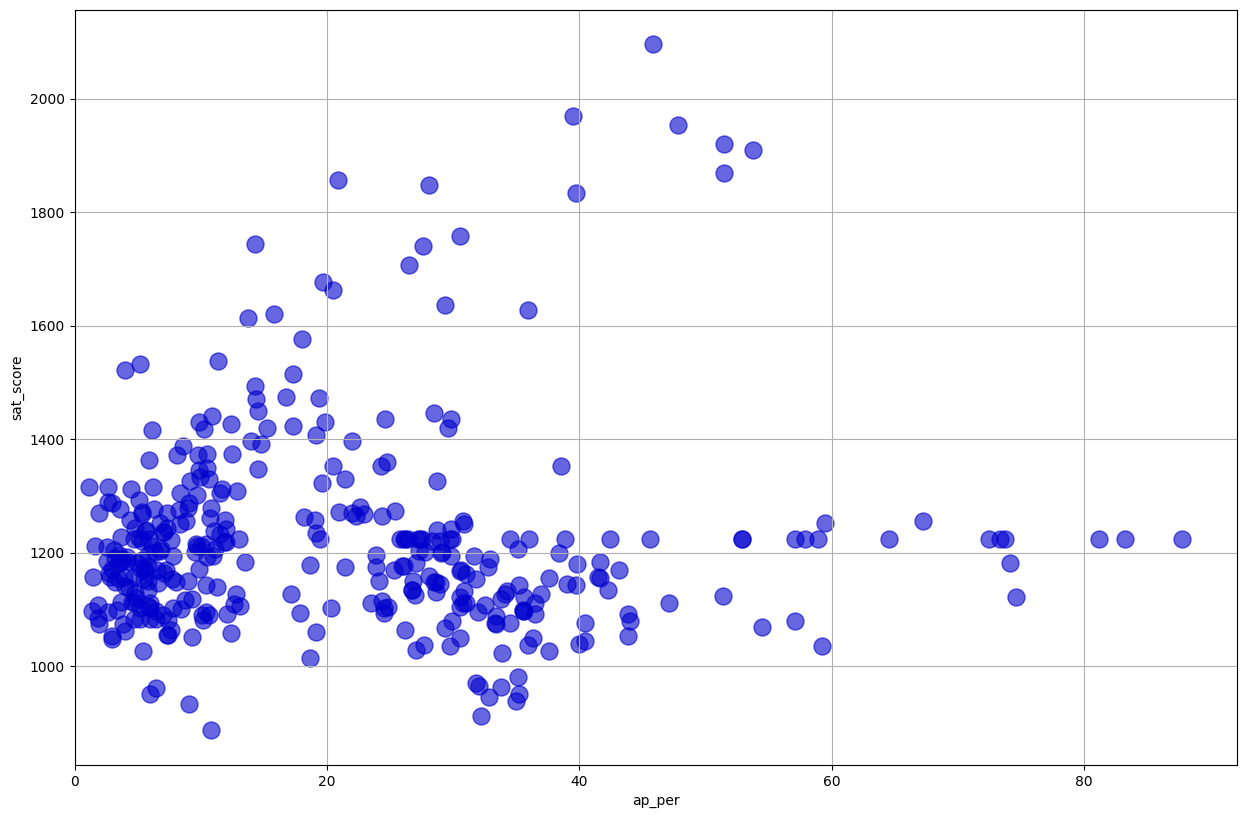

In [28]:
combined['ap_per'] = combined['AP Test Takers '] / combined['total_enrollment'] * 100

combined.plot.scatter('ap_per',
                      'sat_score',
                      s=150,
                      figsize=(15,10),
                      grid='on',
                      alpha=0.6,
                      color='mediumblue',
                      xlim=0)                  

The scatter plot shows a positive correlation, though not spectacularly. The big cluster of schools in the left bottom shows that schools with few AP test takers generally score low SAT results. However, a somewhat smaller cluster is to be found in the 20 to 40 percent range, where schools score comparable SAT results. There is a small group of schools with higher AP test taker percentages that achieve higher SAT scores. However, this might as well be explained by other factors, such as the academic quality of these particular schools.

## 4. Conclusions

In this small project we have made a start with researching various demographic predictors for SAT scores. Our main focus was the fairness of the SAT exam as a de facto admission test for college and university institutions. Analyzing SAT scores among public high schools in New York City, we have managed to find several interesting correlations:

- Schools in wealthier and less densely populated boroughs are likely to score higher than schools in poorer and more densely populated boroughs
- Schools with larger percentages of black and hispanic students are likely to score lower than schools with less black and hispanic students
- The highest scoring schools are magnet schools, offering specialized education and having very competitive admission standards
- Students from a hispanic background are strongly underrepresented in the highest scoring schools

Our findings suggest that standardized tests such as the SAT tend to disadvantage black and hispanic students in multicultural neighborhoods. The gap between racial groups is further widened by the highly competitive entry requirements of the top ranking schools in New York City. Put together, the outcomes of our research suggest that the SAT puts certain groups, especially black and hispanic students, at disadvantage in their academic career. This raises the question whether the SAT is a fair and appropriate instrument for college and university admission processes.